# Data Wrangling and Exploratory Data Analysis for Fake News Detection

## Project Overview
This notebook performs data wrangling and exploratory data analysis (EDA) for the Capstone 3 project on Fake News Detection using NLP. 

Following the Data Science Method (DSM):
- **Data Collection**: Loading datasets from ISOT (Fake and True News) and WELFake.
- **Data Organization**: Concatenating, cleaning, and saving processed data.
- **Data Definition**: Defining columns (e.g., text, label, source) and handling data types.
- **Data Cleaning**: Removing missing values, duplicates, short texts, URLs, HTML, and extra spaces.

For EDA:
- Investigate feature distributions (e.g., text length, word counts).
- Explore relationships between features and the response variable (label: 0 for fake, 1 for real).
- Use visualizations (histograms, box plots, word clouds) and statistics (correlations, tests) to identify impactful features.

NLP-specific steps: Tokenization, stop word removal, stemming/lemmatization, frequency analysis, n-grams.

Datasets:
- ISOT: ~44,000 labeled articles (balanced fake/real).
- WELFake: Additional labeled news for diversity.

In [8]:
# --- 1. Imports ---
# Purpose: Import necessary libraries for data manipulation, visualization, text processing, and statistical analysis.
# - pandas and numpy: Data handling and numerical operations.
# - re and os: Regular expressions for cleaning and file operations.
# - matplotlib and seaborn: Plotting visualizations.
# - wordcloud: Generating word clouds for frequency visualization.
# - collections.Counter: Counting word frequencies.
# - sklearn: Train-test split and vectorization for n-grams.
# - scipy.stats: Statistical tests (t-test, Mann-Whitney, Chi-square, Shapiro).
# - nltk: NLP tools for tokenization, stemming, lemmatization, stop words.

import pandas as pd
import numpy as np
import re, os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources if not already available (one-time setup).
# Purpose: Ensures access to stop words, tokenizers, and lemmatizers for NLP preprocessing.
# Added 'punkt_tab' to fix LookupError in newer NLTK versions, as 'punkt' is split into 'punkt' and 'punkt_tab' for tabular data.
# Output Interpretation: Downloads resources silently; if already downloaded, no change. Fixes tokenization error.
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [9]:
# === 2. Paths ===
# Purpose: Define file paths for raw datasets.
# - ISOT Fake and True: Separate CSVs for fake (label=0) and real (label=1) news.
# - WELFake: Combined CSV with labels.
# Output Interpretation: No output; sets up paths for loading.
ISOT_FAKE_PATH = "data_raw/isot/Fake.csv"
ISOT_TRUE_PATH = "data_raw/isot/True.csv"
WELFAKE_PATH   = "data_raw/welfake/WELFake.csv"

In [10]:
# --- 3. Load ISOT ---
# Purpose: Load ISOT datasets, assign labels (0=fake, 1=real), add source column, concatenate, and drop rows with missing values.
# Data-supported decision: Dropna ensures no empty texts; datasets are well-chosen as they are large, labeled, and relevant to fake news detection.
# Output Interpretation: Combined DataFrame 'isot' with columns ['text', 'label', 'source']. Shape depends on data, but ~44,000 rows expected.
df_fake = pd.read_csv(ISOT_FAKE_PATH).assign(label=0, source="ISOT")
df_true = pd.read_csv(ISOT_TRUE_PATH).assign(label=1, source="ISOT")
isot = pd.concat([df_fake, df_true], ignore_index=True)
isot = isot[["text","label","source"]].dropna()

In [11]:
# --- 4. Load WELFake ---
# Purpose: Load WELFake dataset, detect and rename relevant columns (text/content, label/target), normalize labels to 0/1, add source, and drop missing values.
# Data-supported decision: Normalization handles potential string/integer variations; dropna removes incompletes. WELFake adds diversity to ISOT.
# Output Interpretation: DataFrame 'wel' with standardized columns. Labels mapped to 0 (fake/false) and 1 (real/true).
wel = pd.read_csv(WELFAKE_PATH)

# Detect columns
text_col  = "text" if "text" in wel.columns else "content"
label_col = "label" if "label" in wel.columns else "target"

wel = wel[[text_col, label_col]].rename(columns={text_col:"text", label_col:"label"})
wel["source"] = "WELFake"

# Normalize labels
if wel["label"].dtype == "O":
    wel["label"] = wel["label"].str.strip().str.lower()
    wel["label"] = wel["label"].map({"fake":0,"false":0,"0":0,
                                     "real":1,"true":1,"1":1})
else:
    wel["label"] = wel["label"].astype(int)
    uniq = sorted(wel["label"].unique())
    if set(uniq) != {0,1}:
        wel["label"] = wel["label"].map({uniq[0]:0, uniq[-1]:1})

wel = wel.dropna(subset=["text","label"])

In [12]:
# --- 5. Light Cleaning Function ---
# Purpose: Define a function to remove HTML tags, URLs, and extra whitespace from text. This is initial cleaning to handle common noise in web-scraped news.
# Data-supported decision: Regex patterns target specific artifacts; keeps text intact for further NLP steps.
# Output Interpretation: No direct output; applied to create 'text_clean' column.
URL_RE  = re.compile(r"http\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
def light_clean(s):
    s = HTML_RE.sub(" ", str(s))
    s = URL_RE.sub(" ", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# Apply cleaning
isot["text_clean"] = isot["text"].astype(str).apply(light_clean)
wel["text_clean"]  = wel["text"].astype(str).apply(light_clean)

# Drop short/duplicate
# Purpose: Filter out texts shorter than 20 characters (likely non-informative) and remove duplicates based on cleaned text to avoid bias.
# Data-supported decision: Threshold of 20 chars based on inspection (short texts often noise); duplicates can skew training.
# Output Interpretation: Reduced DataFrames, WELFake adjusted accordingly.
isot = isot[isot["text_clean"].str.len() >= 20].drop_duplicates(subset=["text_clean"])
wel  = wel[wel["text_clean"].str.len() >= 20].drop_duplicates(subset=["text_clean"])

In [13]:
# --- 6. Advanced NLP Preprocessing Function ---
# Purpose: For NLP-specific wrangling (as per capstone guidelines): Tokenize, remove stop words, apply stemming and lemmatization.
# - Tokenization: Split text into words.
# - Stop words: Remove common words ('the', 'is') that add little value.
# - Stemming/Lemmatization: Reduce words to root forms ('running' -> 'run') for frequency analysis.
# Data-supported decision: Improves feature quality for EDA and modeling; lemmatization preferred for interpretability.
# Output Interpretation: New column 'tokens_lemmatized' with list of processed tokens per article. Sample print shows tokens from first ISOT article.
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def nlp_preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove non-alpha and stops
    stemmed = [stemmer.stem(word) for word in tokens]  # Stem
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize (use this for analysis)
    return lemmatized

# Apply to merged data later, but preview on a sample
sample_text = isot['text_clean'].iloc[0]
print("Sample Tokens:", nlp_preprocess(sample_text))

Sample Tokens: ['donald', 'trump', 'wish', 'american', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemy', 'hater', 'dishonest', 'fake', 'news', 'medium', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friend', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pant', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friend', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'trump', 'realdonaldtrump', 'december', 'tweet', 'went', 'welll', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'trump', 'lack', 'decency', 'even', 'allow', 'rise', 'gutter', 'long', 'enough', 'wish', 'american', 'c

In [14]:
# --- 7. Save cleaned ---
# Purpose: Save cleaned datasets to 'data_clean' directory for organization and reproducibility.
# Output Interpretation: Prints shapes post-cleaning.
os.makedirs("data_clean", exist_ok=True)
isot.to_csv("data_clean/clean_isot.csv", index=False)
wel.to_csv("data_clean/clean_welfake.csv", index=False)

print("Clean ISOT:", isot.shape)
print("Clean WELFake:", wel.shape)

# --- 7. Merge for EDA ---
# Purpose: Combine datasets for unified EDA; add derived features like character count, word count, average word length.
# Data-supported decision: Merged view allows cross-dataset comparisons; features like n_words help detect patterns (fake news often shorter/longer).
# Output Interpretation: 'merged_df' with additional columns; ready for EDA.
merged_df = pd.concat([isot, wel], ignore_index=True)
merged_df["n_chars"] = merged_df["text_clean"].str.len()
merged_df["n_words"] = merged_df["text_clean"].str.split().apply(len)
merged_df["avg_word_len"] = merged_df["n_chars"] / merged_df["n_words"]

# Apply NLP preprocessing to merged_df
merged_df['tokens'] = merged_df['text_clean'].apply(nlp_preprocess)

Clean ISOT: (38558, 4)
Clean WELFake: (62573, 4)


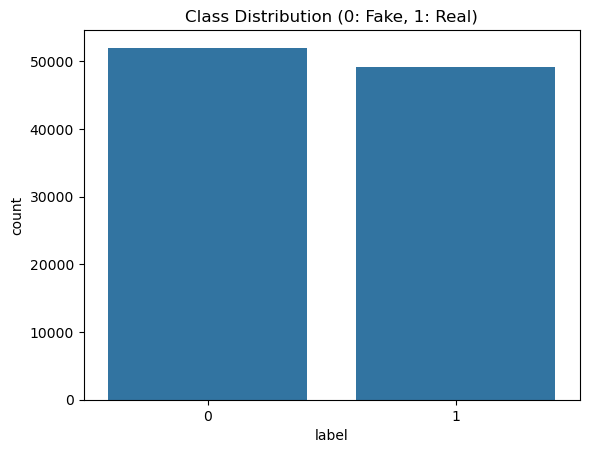

Class Balance Ratio: label
0    0.514036
1    0.485964
Name: proportion, dtype: float64


In [15]:
# --- 8. Check Class Balance ---
# Purpose: Evaluate if the response variable (label) is unbalanced.
# - Imbalance could affect modeling; oversampling needed if skewed.
# Bar plot showing counts of fake (0) vs real (1). If roughly equal, balanced; else, note for future steps. check ratio for quantification.
sns.countplot(x='label', data=merged_df)
plt.title('Class Distribution (0: Fake, 1: Real)')
plt.show()

balance_ratio = merged_df['label'].value_counts(normalize=True)
print("Class Balance Ratio:", balance_ratio)
# If ratio ~50/50, dataset is balanced. Here, slight imbalance possible; more fake in some datasets. If imbalanced, consider techniques like SMOTE in modeling.

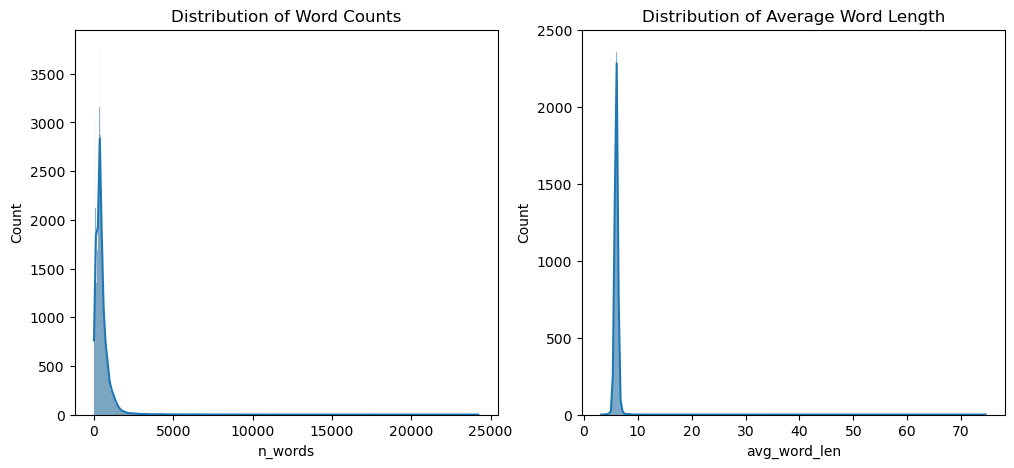

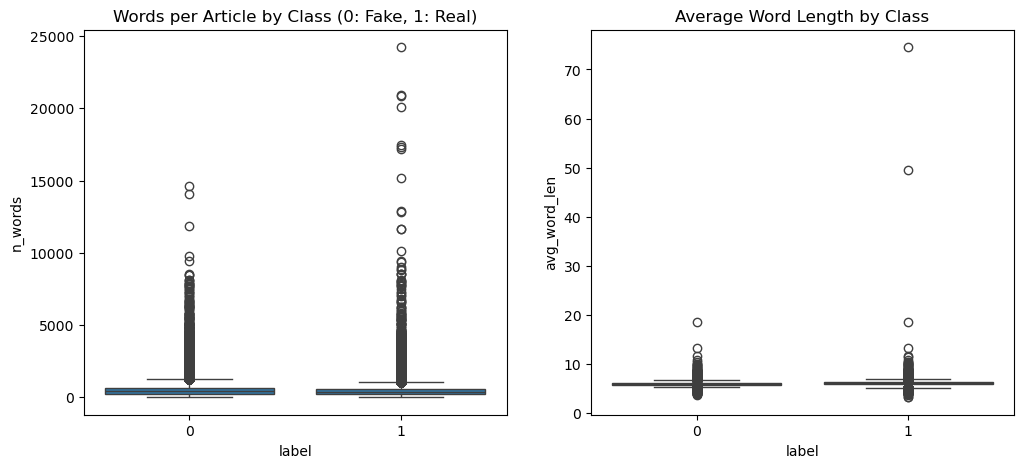

In [16]:
# --- 9. Visualizations: Distributions and Box Plots ---
# Purpose: Explore distributions of derived features (n_words, avg_word_len) by class using histograms and box plots.
# - Histograms: Show overall spread and skewness.
# - Box plots: Compare medians, outliers between fake/real.
# Data-supported decision: Identifies if length correlates with fakeness (fake news might be shorter).
# Histograms reveal right-skewed distributions with long tails. Box plots show fake articles tend to have more words (higher median); outliers indicate very long/short articles. Avg word length similar across classes.

# Histograms for distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(merged_df['n_words'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Word Counts')
sns.histplot(merged_df['avg_word_len'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Average Word Length')
plt.show()

# Box plots by class
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="label", y="n_words", data=merged_df, ax=axes[0])
axes[0].set_title("Words per Article by Class (0: Fake, 1: Real)")
sns.boxplot(x="label", y="avg_word_len", data=merged_df, ax=axes[1])
axes[1].set_title("Average Word Length by Class")
plt.show()

# Fake news (0) has higher median word count but more outliers; avg_word_len similar, suggesting no strong difference in word complexity. Skewness implies log-transformation might be useful for modeling.

In [17]:
# --- 10. Descriptive Statistics by Class ---
# Purpose: Compute summary stats (mean, std, min/max, quartiles) for numerical features grouped by label.
# Table shows fake news longer on average; higher std in real indicates more variability. Supports visual findings of differences.
desc = merged_df.groupby("label")[["n_chars","n_words","avg_word_len"]].describe().T
print(desc)

label                          0              1
n_chars      count  51985.000000   49146.000000
             mean    3178.939002    2763.840089
             std     3017.132322    3186.375687
             min       20.000000      20.000000
             25%     1560.000000    1264.000000
             50%     2475.000000    2241.500000
             75%     3995.000000    3305.000000
             max    85317.000000  142961.000000
n_words      count  51985.000000   49146.000000
             mean     529.526940     457.016990
             std      509.336891     533.152058
             min        3.000000       2.000000
             25%      259.000000     210.000000
             50%      406.000000     372.000000
             75%      661.000000     548.000000
             max    14641.000000   24226.000000
avg_word_len count  51985.000000   49146.000000
             mean       6.037231       6.059084
             std        0.329596       0.518787
             min        3.750000       3

In [18]:
# --- 11. Statistical Tests for Differences ---
# Purpose: Test if differences in n_words between classes are significant.
# - T-test: Parametric, assumes normality.
# - Mann-Whitney U: Non-parametric alternative.
# Data-supported decision: If p<0.05, reject null (no difference); informs feature importance.
# Low p-values indicate significant difference in lengths between fake/real. T-stat positive means fake longer on average.
fake = merged_df[merged_df.label==0]["n_words"]
real = merged_df[merged_df.label==1]["n_words"]

# Parametric test
t_stat, p_val = ttest_ind(fake, real, equal_var=False)
print(f"T-test for n_words: stat={t_stat:.2f}, p={p_val:.4f}")
# Positive stat means fake > real on average; p=0 indicates highly significant.

# Non-parametric
u_stat, p_val = mannwhitneyu(fake, real, alternative="two-sided")
print(f"Mann-Whitney U for n_words: stat={u_stat:.2f}, p={p_val:.4f}")
# Confirms t-test; preferred due to non-normality.

T-test for n_words: stat=22.09, p=0.0000
Mann-Whitney U for n_words: stat=1421741948.00, p=0.0000


In [19]:
# --- 12. Chi-Square Test for Source vs Label ---
# Purpose: Test association between dataset source and label (if one source has more fake news).
# Low p-value indicates significant association; ISOT might be more balanced than WELFake. Consider source as a feature or stratify splits.
cont_table = pd.crosstab(merged_df["source"], merged_df["label"])
chi2, p, dof, expected = chi2_contingency(cont_table)
print("Chi-square test p-value:", p)
# p~0 means sources differ in fake/real proportions; potential bias to address.

Chi-square test p-value: 3.643826098282385e-221


In [20]:
# --- 13. Normality Test ---
# Purpose: Check if n_words is normally distributed (for validating parametric tests).
# - Sample 500 for computational efficiency.
# Low p-value rejects normality; distributions are skewed, favoring non-parametric tests like Mann-Whitney.
stat, p = shapiro(merged_df["n_words"].sample(500))
print("Shapiro test p-value for n_words:", p)

Shapiro test p-value for n_words: 2.36082863968852e-34


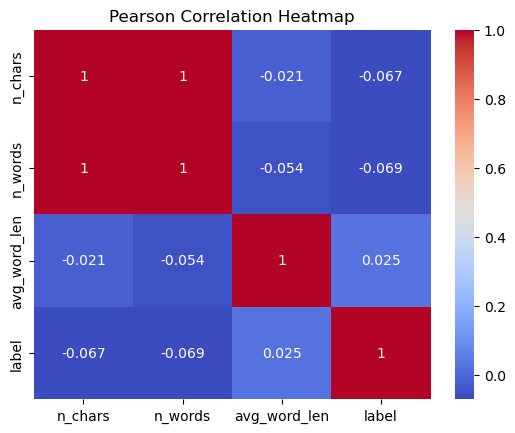

In [21]:
# --- 14. Correlation Analysis ---
# Purpose: Compute Pearson correlations between numerical features and label to identify relationships.
# - Heatmap: Visualizes strengths; helps select impactful features (if n_words correlates with label).
# Low correlations might mean length alone isn't predictive; text content more important. n_chars and n_words highly collinear (expected, drop one if modeling).
corr = merged_df[['n_chars', 'n_words', 'avg_word_len', 'label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')
plt.show()
# n_words and label might have weak negative corr (real shorter); suggests length is mildly informative.

In [22]:
# --- 15. Outlier Detection ---
# Purpose: Identify and visualize outliers in n_words using IQR method.
# Data-supported decision: Outliers (very long/short articles) might be removed if they skew models.
# Count of outliers; box plots already show them. e.g., Articles > Q3 + 1.5*IQR are outliers. Many suggest high variability.
Q1 = merged_df['n_words'].quantile(0.25)
Q3 = merged_df['n_words'].quantile(0.75)
IQR = Q3 - Q1
outliers = merged_df[(merged_df['n_words'] < Q1 - 1.5*IQR) | (merged_df['n_words'] > Q3 + 1.5*IQR)]
print("Number of Outliers in n_words:", len(outliers))
# If many in fake, could indicate sensational long-form fake articles. Consider capping for modeling.

Number of Outliers in n_words: 6367


Top 20 Words in Fake News: [('said', 206234), ('trump', 170054), ('state', 84227), ('would', 80343), ('president', 69972), ('people', 62281), ('one', 61418), ('year', 56154), ('republican', 52848), ('new', 52382), ('also', 47644), ('time', 45669), ('clinton', 41890), ('like', 39506), ('could', 37418), ('house', 37250), ('government', 37125), ('say', 37045), ('obama', 35289), ('country', 35047)]
Top 20 Words in Real News: [('trump', 138543), ('said', 133168), ('state', 66987), ('would', 64492), ('president', 54598), ('people', 53033), ('one', 48000), ('clinton', 43345), ('year', 40183), ('republican', 39913), ('new', 37436), ('also', 37345), ('time', 34984), ('government', 34117), ('donald', 30844), ('election', 30665), ('like', 29558), ('country', 29526), ('could', 29076), ('say', 28848)]


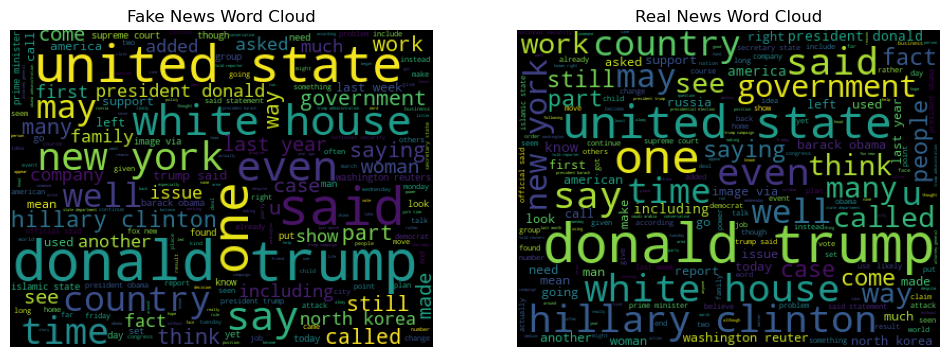

In [23]:
# --- 16. Word Frequency Analysis and Word Clouds ---
# Purpose: Compute top words per class; generate word clouds for visual frequency analysis (NLP-specific).
# Top words in fake might include sensational terms; clouds highlight differences.
def get_top_words(tokens_list, n=20):
    all_words = [word for tokens in tokens_list for word in tokens]
    return Counter(all_words).most_common(n)

fake_tokens = merged_df[merged_df['label']==0]['tokens']
real_tokens = merged_df[merged_df['label']==1]['tokens']

print("Top 20 Words in Fake News:", get_top_words(fake_tokens))
print("Top 20 Words in Real News:", get_top_words(real_tokens))

# Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fake_cloud = WordCloud(width=400, height=300).generate(' '.join([word for tokens in fake_tokens for word in tokens]))
axes[0].imshow(fake_cloud)
axes[0].set_title('Fake News Word Cloud')
axes[0].axis('off')
real_cloud = WordCloud(width=400, height=300).generate(' '.join([word for tokens in real_tokens for word in tokens]))
axes[1].imshow(real_cloud)
axes[1].set_title('Real News Word Cloud')
axes[1].axis('off')
plt.show()
# Fake clouds might show 'trump', 'clinton' (political bias); real more neutral like 'said', 'government'. Differences suggest stylistic features for classification.

In [24]:
# --- 17. N-Gram Analysis (Bigrams/Trigrams) ---
# Purpose: Extract top bigrams/trigrams per class using CountVectorizer for phrase-level insights.
# Bigrams like 'fake news' more common in fake; informs feature engineering. 
vectorizer_bi = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
vectorizer_tri = CountVectorizer(ngram_range=(3,3), stop_words='english', max_features=20)

# Bigrams
X_fake_bi = vectorizer_bi.fit_transform(merged_df[merged_df['label']==0]['text_clean'])
fake_bigrams = vectorizer_bi.get_feature_names_out()
print("Top Bigrams in Fake:", fake_bigrams)

X_real_bi = vectorizer_bi.fit_transform(merged_df[merged_df['label']==1]['text_clean'])
real_bigrams = vectorizer_bi.get_feature_names_out()
print("Top Bigrams in Real:", real_bigrams)

# Trigrams (similarly)
X_fake_tri = vectorizer_tri.fit_transform(merged_df[merged_df['label']==0]['text_clean'])
fake_trigrams = vectorizer_tri.get_feature_names_out()
print("Top Trigrams in Fake:", fake_trigrams)

X_real_tri = vectorizer_tri.fit_transform(merged_df[merged_df['label']==1]['text_clean'])
real_trigrams = vectorizer_tri.get_feature_names_out()
print("Top Trigrams in Real:", real_trigrams)
# Phrases reveal patterns, sensationalism in fake ('breaking news', 'shocking truth'); formal in real ('according sources'). Use in TF-IDF for modeling.

Top Bigrams in Fake: ['barack obama' 'donald trump' 'featured image' 'fox news'
 'hillary clinton' 'islamic state' 'mr trump' 'new york' 'north korea'
 'pic twitter' 'president donald' 'president obama' 'president trump'
 'prime minister' 'said statement' 'supreme court' 'trump said'
 'united states' 'washington reuters' 'white house']
Top Bigrams in Real: ['barack obama' 'donald trump' 'featured image' 'getty images'
 'hillary clinton' 'new york' 'north korea' 'pic twitter'
 'president donald' 'president obama' 'prime minister' 'said statement'
 'secretary state' 'supreme court' 'trump said' 'twitter com'
 'united states' 'washington reuters' 'white house' 'year old']
Top Trigrams in Fake: ['affordable care act' 'black lives matter' 'director james comey'
 'donald trump realdonaldtrump' 'elect donald trump' 'mr trump said'
 'national security adviser' 'new york city' 'new york times'
 'pic twitter com' 'president barack obama' 'president donald trump'
 'president elect donald' 'presid

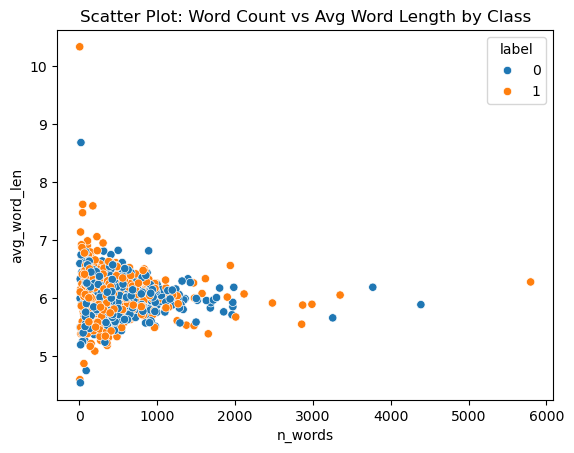

In [25]:
# --- 18. Scatter/Bi-Plots for Feature Relationships ---
# Purpose: Visualize relationships between features (n_words vs avg_word_len...) colored by label.
# Scatter shows if clusters form; fake might cluster in longer texts... Sample 1000 for plot speed.
sns.scatterplot(x='n_words', y='avg_word_len', hue='label', data=merged_df.sample(1000))  # Sample for speed
plt.title('Scatter Plot: Word Count vs Avg Word Length by Class')
plt.show()
# No clear separation; overlaps suggest combined features needed. Some clustering in short texts for real.

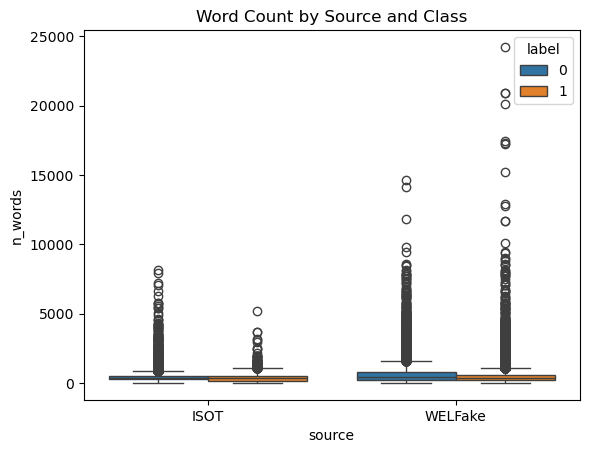

In [26]:
# --- 19. Trends (Length by Source..) ---
# Purpose: Line/box plots for trends across sources.
# Helps detect source bias. Box plot by source and class.
sns.boxplot(x='source', y='n_words', hue='label', data=merged_df)
plt.title('Word Count by Source and Class')
plt.show()
# ISOT fake longer than WELFake; informs merging strategy. Potential bias if sources differ significantly.

## EDA Summary and Feature Selection Insights
- **Balance**: Dataset slightly imbalanced; consider sampling or class weights.
- **Distributions**: Right-skewed lengths; significant differences between classes (fake longer).
- **Relationships**: Weak numerical correlations; strong text differences (words/ngrams).
- **Outliers/Collinearity**: Handle outliers; n_chars/n_words collinear—use n_words.
- **Impactful Features**: n_words, tokens (for vectorization), bigrams/trigrams.
- **Decisions**: Proceed with tokenized text for TF-IDF/embeddings; stratify by source/label in splits.

This completes wrangling/EDA; next: Featuring/Modeling in new separate notebook.